All Packages I might need

In [5]:
import numpy as np
from numpy.random import randn

import pandas as pd
from pandas import Series, DataFrame
from pandas.plotting import scatter_matrix

import math as m

import time as t

In [6]:
MLB_DF=pd.DataFrame(pd.read_csv('MLB_Scores_Clean.csv'))

In [7]:
#Remove ties from the data since these games were replayed anyways
MLB_DF=MLB_DF[MLB_DF.VisitScore!=MLB_DF.HomeScore]

In [8]:
#Set up data so that each game has a row for the home team and away team
MLB_DF_Home=MLB_DF.drop(['Visitor','Visit_League','HomeLeague'],axis=1)
MLB_DF_Home=MLB_DF_Home.rename(columns={'Home':'Team','VisitScore':'HomeAgainst','HomeScore':'HomeFor'})
MLB_DF_Home['For']=MLB_DF_Home.HomeFor
MLB_DF_Home['Against']=MLB_DF_Home.HomeAgainst
MLB_DF_Home['HomeResult']=np.where(MLB_DF.HomeScore>MLB_DF.VisitScore,1,0)
MLB_DF_Home['Result']=MLB_DF_Home.HomeResult
MLB_DF_Home['AwayFor']=np.NaN #empty road columns
MLB_DF_Home['AwayAgainst']=np.NaN
MLB_DF_Home['AwayResult']=np.NaN

MLB_DF_Away=MLB_DF.drop(['Home','Visit_League','HomeLeague'],axis=1)
MLB_DF_Away=MLB_DF_Away.rename(columns={'Visitor':'Team','VisitScore':'AwayFor','HomeScore':'AwayAgainst'})
MLB_DF_Away['For']=MLB_DF_Away.AwayFor
MLB_DF_Away['Against']=MLB_DF_Away.AwayAgainst
MLB_DF_Away['AwayResult']=np.where(MLB_DF_Away.For>MLB_DF_Away.Against,1,0)
MLB_DF_Away['Result']=MLB_DF_Away.AwayResult
MLB_DF_Away['HomeFor']=np.NaN #empty road columns
MLB_DF_Away['HomeAgainst']=np.NaN
MLB_DF_Away['HomeResult']=np.NaN

MLB_DF_All=MLB_DF_Home.append(MLB_DF_Away,ignore_index=True)

In [12]:
#Group By Season and Team
MLB_DF=MLB_DF_All.groupby(['Season','Team']).mean()

Test for best Pythagorean Formula

In [10]:
test2=[]
for p in np.linspace(0,4,9):
    MLB_Final['PythagWin']=MLB_Final.For**p/(MLB_Final.For**p+MLB_Final.Against**p)
    MLB_Final['SqErr']=(MLB_Final.Result-MLB_Final.PythagWin)**2
    test2.append({'p':p,'SqErr':sum(MLB_Final.SqErr)})
test2_df=pd.DataFrame(test2)
test2_df

,p,SqErr
0,0.0,3.167387
1,0.5,1.844337
2,1.0,0.947822
3,1.5,0.470495
4,2.0,0.394119
5,2.5,0.691655
6,3.0,1.329781
7,3.5,2.271421
8,4.0,3.477995


p=2 provides the best results, as expected

In [11]:
#See win rate of home teams in all games
MLB_DF_All.HomeResult.mean(),MLB_DF_All.AwayResult.mean()

(0.5387797949857972, 0.4612202050142028)

All single-computation commands for simulations

In [52]:
MLB_DF.reset_index(level=0, inplace=True)
p_MLB=2
MLB_DF['PythagHome']=MLB_DF.apply(lambda x: x['HomeFor']**p_MLB/(x['HomeFor']**p_MLB+x['HomeAgainst']**p_MLB),axis=1)
MLB_DF['PythagAway']=MLB_DF.apply(lambda x: x['AwayFor']**p_MLB/(x['AwayFor']**p_MLB+x['AwayAgainst']**p_MLB),axis=1)
MLB_DF['Pythag']=MLB_DF.apply(lambda x: x['For']**p_MLB/(x['For']**p_MLB+x['Against']**p_MLB),axis=1)
MLB_DF['SeasRank'] = MLB_DF.groupby(['Season'])['Pythag'].rank(method='first', ascending=False)

MLB_DF.groupby('SeasRank').mean().to_csv('MLB_Averages.csv')
MLB_Averages=MLB_DF.groupby('SeasRank').mean()

HF_Avg=MLB_DF.HomeFor.mean()
HA_Avg=MLB_DF.HomeAgainst.mean()

MLB_Sched=pd.DataFrame(pd.read_excel('MLB_Schedule.xlsx'))
MLB_Sched=MLB_Sched.drop(['Away Rank','Home Rank'],axis=1)

def Sim(F,A):
    r=np.random.rand()
    p=F**p_MLB/(F**p_MLB+A**p_MLB)
    if r<p:
        return 1
    elif r>p:
        return 0
    else:
        return 0.5
    
def FullGameSim(HF,HA,AF,AA,Avg_HF,Avg_HA):
    HF_Adj=(HF*AA)/Avg_HF
    AF_Adj=(AF*HA)/Avg_HA
    g=Sim(HF_Adj,AF_Adj)
    return g,HF_Adj,AF_Adj


All iterative simulations

In [53]:
t_start=t.time()
n_sim=1
Results=[]
for sim in range(0,n_sim):
    MLB_Ranks=pd.DataFrame(data={'TeamID':MLB_Sched['Away ID'].unique(),'TeamRank':np.random.rand(30)})
    MLB_Ranks.TeamRank=MLB_Ranks.TeamRank.rank(method='first', ascending=False) #replace randoms with ranks
    MLB_Ranks['League']=MLB_Ranks['TeamID'].str[:2] #Convert to string, grab first 2
    MLB_Ranks['Division']=MLB_Ranks['TeamID'].str[2:3] #convert to string, characters [2,3)
    MLB_Ranks=MLB_Ranks.sort_values(by=['TeamID'])

    MLB_Sched['AwayRank']=MLB_Sched.apply(lambda x: MLB_Ranks.loc[MLB_Ranks['TeamID'] == x['Away ID']].iloc[0,1] ,axis=1)
    MLB_Sched['HomeRank']=MLB_Sched.apply(lambda x: MLB_Ranks.loc[MLB_Ranks['TeamID'] == x['Home ID']].iloc[0,1] ,axis=1)

    MLB_Sched['HomeResult']=MLB_Sched.apply(lambda x: FullGameSim(
        MLB_Averages.iloc[int(x['HomeRank']-1),2]
        ,MLB_Averages.iloc[int(x['HomeRank']-1),1]
        ,MLB_Averages.iloc[int(x['AwayRank']-1),7]
        ,MLB_Averages.iloc[int(x['AwayRank']-1),8]
        ,HF_Avg,HA_Avg)[0], axis=1)

    MLB_Ranks['Result']=np.zeros(30)
    for i in range(1,31):
        MLB_Ranks.iloc[i-1,4]=(MLB_Sched.groupby('HomeRank').mean().HomeResult[MLB_Ranks.iloc[i-1,1]]+
                                   (1-MLB_Sched.groupby('AwayRank').mean().HomeResult[MLB_Ranks.iloc[i-1,1]]))/2
    MLB_Ranks['Wins']=162*MLB_Ranks['Result']
    MLB_Ranks['Losses']=162*(1-MLB_Ranks['Result'])

    MLB_Ranks['MLBRank']=MLB_Ranks.Result.rank(method='first', ascending=False)
    MLB_Ranks['LeagueRank']=MLB_Ranks.groupby('League').Result.rank(method='first', ascending=False)
    MLB_Ranks['DivRank']=MLB_Ranks.groupby(['League','Division']).Result.rank(method='first', ascending=False)
    MLB_Ranks['LeagueSeed']=np.where(MLB_Ranks.DivRank==1,0,100)+MLB_Ranks.LeagueRank
    MLB_Ranks['LeagueSeed']=MLB_Ranks.groupby('League').LeagueSeed.rank(method='first', ascending=True)
    MLB_Ranks['PlayoffResult']='None' #Say "none" for each team. Playoff teams updated later
    MLB_Ranks['Sim']=sim #save run number

    MLB_Post_Sched=pd.read_excel('MLB_playoffs.xlsx')
    #Playoff Simulations
    MLB_Post_Sched['Result']=np.NAN

    #Byes
    MLB_Post_Sched.iloc[2:7,6]=MLB_Ranks.loc[(MLB_Ranks.League==MLB_Post_Sched.iloc[2,0])&
                                           (MLB_Ranks.LeagueSeed==MLB_Post_Sched.iloc[2,3])].iloc[0,0] #NL 1-seed
    MLB_Post_Sched.iloc[7:12,6]=MLB_Ranks.loc[(MLB_Ranks.League==MLB_Post_Sched.iloc[7,0])&
                                           (MLB_Ranks.LeagueSeed==MLB_Post_Sched.iloc[7,3])].iloc[0,0] #NL 2-seed
    MLB_Post_Sched.iloc[7:12,7]=MLB_Ranks.loc[(MLB_Ranks.League==MLB_Post_Sched.iloc[7,0])&
                                           (MLB_Ranks.LeagueSeed==MLB_Post_Sched.iloc[7,4])].iloc[0,0] #NL 3-seed
    MLB_Post_Sched.iloc[12:17,6]=MLB_Ranks.loc[(MLB_Ranks.League==MLB_Post_Sched.iloc[12,0])&
                                           (MLB_Ranks.LeagueSeed==MLB_Post_Sched.iloc[12,3])].iloc[0,0] #AL 1-seed
    MLB_Post_Sched.iloc[17:22,6]=MLB_Ranks.loc[(MLB_Ranks.League==MLB_Post_Sched.iloc[17,0])&
                                           (MLB_Ranks.LeagueSeed==MLB_Post_Sched.iloc[17,3])].iloc[0,0] #AL 2-seed
    MLB_Post_Sched.iloc[17:22,7]=MLB_Ranks.loc[(MLB_Ranks.League==MLB_Post_Sched.iloc[17,0])&
                                           (MLB_Ranks.LeagueSeed==MLB_Post_Sched.iloc[17,4])].iloc[0,0] #AL 3-seed
    #NLWC
    r=0
    MLB_Post_Sched.iloc[r,6]=MLB_Ranks.loc[(MLB_Ranks.League==MLB_Post_Sched.iloc[r,0])&
                                           (MLB_Ranks.LeagueSeed==MLB_Post_Sched.iloc[r,3])].iloc[0,0] #Fill in HigherSeedID
    MLB_Post_Sched.iloc[r,7]=MLB_Ranks.loc[(MLB_Ranks.League==MLB_Post_Sched.iloc[r,0])&
                                           (MLB_Ranks.LeagueSeed==MLB_Post_Sched.iloc[r,4])].iloc[0,0] #Fill in LowerSeedID
    HighRank=MLB_Ranks.loc[MLB_Ranks['TeamID'] == MLB_Post_Sched.iloc[r,6]].iloc[0,1] #Higher Seed Rank
    LowRank=MLB_Ranks.loc[MLB_Ranks['TeamID'] == MLB_Post_Sched.iloc[r,7]].iloc[0,1] #Lower Seed Rank
    #Higher seed always at home in WCG
    g=FullGameSim(
        MLB_Averages.iloc[int(HighRank-1),2]
        ,MLB_Averages.iloc[int(HighRank-1),1]
        ,MLB_Averages.iloc[int(LowRank-1),7]
        ,MLB_Averages.iloc[int(LowRank-1),8]
        ,HF_Avg,HA_Avg)[0]
    if g==1:
        MLB_Post_Sched.iloc[r,8]='Higher' #Higher seed won
        MLB_Post_Sched.iloc[2:7,7]=MLB_Post_Sched.iloc[r,6] #Higher seed advances to DS
        MLB_Post_Sched.iloc[2:7,4]=MLB_Post_Sched.iloc[r,3] #Write their seed to DS seed column
        MLB_Ranks.loc[MLB_Ranks.TeamID==MLB_Post_Sched.iloc[r,7],'PlayoffResult']='WCG' #Note that lower seed lost in WC game
    else:
        MLB_Post_Sched.iloc[r,8]='Lower'
        MLB_Post_Sched.iloc[2:7,7]=MLB_Post_Sched.iloc[r,7]
        MLB_Post_Sched.iloc[2:7,4]=MLB_Post_Sched.iloc[r,4]
        MLB_Ranks.loc[MLB_Ranks.TeamID==MLB_Post_Sched.iloc[r,6],'PlayoffResult']='WCG' #Note that higher seed lost in WC game


    #ALWC
    r=1
    MLB_Post_Sched.iloc[r,6]=MLB_Ranks.loc[(MLB_Ranks.League==MLB_Post_Sched.iloc[r,0])&
                                           (MLB_Ranks.LeagueSeed==MLB_Post_Sched.iloc[r,3])].iloc[0,0] #Fill in HigherSeedID
    MLB_Post_Sched.iloc[r,7]=MLB_Ranks.loc[(MLB_Ranks.League==MLB_Post_Sched.iloc[r,0])&
                                           (MLB_Ranks.LeagueSeed==MLB_Post_Sched.iloc[r,4])].iloc[0,0] #Fill in LowerSeedID
    HighRank=MLB_Ranks.loc[MLB_Ranks['TeamID'] == MLB_Post_Sched.iloc[r,6]].iloc[0,1] #Higher Seed Rank
    LowRank=MLB_Ranks.loc[MLB_Ranks['TeamID'] == MLB_Post_Sched.iloc[r,7]].iloc[0,1] #Lower Seed Rank
    #Higher seed always at home in WCG
    g=FullGameSim(
        MLB_Averages.iloc[int(HighRank-1),2]
        ,MLB_Averages.iloc[int(HighRank-1),1]
        ,MLB_Averages.iloc[int(LowRank-1),7]
        ,MLB_Averages.iloc[int(LowRank-1),8]
        ,HF_Avg,HA_Avg)[0]
    if g==1:
        MLB_Post_Sched.iloc[r,8]='Higher'
        MLB_Post_Sched.iloc[12:17,7]=MLB_Post_Sched.iloc[r,6]
        MLB_Post_Sched.iloc[12:17,4]=MLB_Post_Sched.iloc[r,3]
        MLB_Ranks.loc[MLB_Ranks.TeamID==MLB_Post_Sched.iloc[r,7],'PlayoffResult']='WCG'
    else:
        MLB_Post_Sched.iloc[r,8]='Lower'
        MLB_Post_Sched.iloc[12:17,7]=MLB_Post_Sched.iloc[r,7]
        MLB_Post_Sched.iloc[12:17,4]=MLB_Post_Sched.iloc[r,4]
        MLB_Ranks.loc[MLB_Ranks.TeamID==MLB_Post_Sched.iloc[r,6],'PlayoffResult']='WCG'

    #NLDS1
    HighRank=MLB_Ranks.loc[MLB_Ranks['TeamID'] == MLB_Post_Sched.iloc[3,6]].iloc[0,1] #Higher Seed Rank
    LowRank=MLB_Ranks.loc[MLB_Ranks['TeamID'] == MLB_Post_Sched.iloc[3,7]].iloc[0,1] #Lower Seed Rank
    HigherSeriesScore=0
    LowerSeriesScore=0
    for r in range(2,7):
        if MLB_Post_Sched.iloc[r,5]=='Higher':#Higher Seed at home
            g=FullGameSim(
                MLB_Averages.iloc[int(HighRank-1),2]
                ,MLB_Averages.iloc[int(HighRank-1),1]
                ,MLB_Averages.iloc[int(LowRank-1),7]
                ,MLB_Averages.iloc[int(LowRank-1),8]
                ,HF_Avg,HA_Avg)[0]
            if g==1:
                MLB_Post_Sched.iloc[r,8]='Higher' #Higher seed won
                HigherSeriesScore=HigherSeriesScore+1
            else:
                MLB_Post_Sched.iloc[r,8]='Lower'
                LowerSeriesScore=LowerSeriesScore+1
        else:
            g=FullGameSim(
                MLB_Averages.iloc[int(LowRank-1),2]
                ,MLB_Averages.iloc[int(LowRank-1),1]
                ,MLB_Averages.iloc[int(HighRank-1),7]
                ,MLB_Averages.iloc[int(HighRank-1),8]
                ,HF_Avg,HA_Avg)[0]
            if g==0:
                MLB_Post_Sched.iloc[r,8]='Higher'
                HigherSeriesScore=HigherSeriesScore+1
            else:
                MLB_Post_Sched.iloc[r,8]='Lower'
                LowerSeriesScore=LowerSeriesScore+1
        if HigherSeriesScore==3:
            MLB_Post_Sched.iloc[22:29,3]=MLB_Post_Sched.iloc[r,3] #Higher seed to NLCS
            MLB_Post_Sched.iloc[22:29,6]=MLB_Post_Sched.iloc[r,6] #Fill in Team ID
            NLDS1_Win=1 #Save that higher seed won
            MLB_Ranks.loc[MLB_Ranks.TeamID==MLB_Post_Sched.iloc[r,7],'PlayoffResult']='DS' #lower seed lost in DS
            break
        elif LowerSeriesScore==3:
            MLB_Post_Sched.iloc[22:29,4]=MLB_Post_Sched.iloc[r,4] #Lower seed to NLCS
            MLB_Post_Sched.iloc[22:29,7]=MLB_Post_Sched.iloc[r,7] #Fill in Team ID
            NLDS1_Win=4 #Save that lower seed won
            MLB_Ranks.loc[MLB_Ranks.TeamID==MLB_Post_Sched.iloc[r,6],'PlayoffResult']='DS' #higher seed lost in DS
            break

    #NLDS2
    HighRank=MLB_Ranks.loc[MLB_Ranks['TeamID'] == MLB_Post_Sched.iloc[7,6]].iloc[0,1] #Higher Seed Rank
    LowRank=MLB_Ranks.loc[MLB_Ranks['TeamID'] == MLB_Post_Sched.iloc[7,7]].iloc[0,1] #Lower Seed Rank
    HigherSeriesScore=0
    LowerSeriesScore=0
    for r in range(7,12):
        if MLB_Post_Sched.iloc[r,5]=='Higher':#Higher Seed at home
            g=FullGameSim(
                MLB_Averages.iloc[int(HighRank-1),2]
                ,MLB_Averages.iloc[int(HighRank-1),1]
                ,MLB_Averages.iloc[int(LowRank-1),7]
                ,MLB_Averages.iloc[int(LowRank-1),8]
                ,HF_Avg,HA_Avg)[0]
            if g==1:
                MLB_Post_Sched.iloc[r,8]='Higher' #Higher seed won
                HigherSeriesScore=HigherSeriesScore+1
            else:
                MLB_Post_Sched.iloc[r,8]='Lower'
                LowerSeriesScore=LowerSeriesScore+1
        else:
            g=FullGameSim(
                MLB_Averages.iloc[int(LowRank-1),2]
                ,MLB_Averages.iloc[int(LowRank-1),1]
                ,MLB_Averages.iloc[int(HighRank-1),7]
                ,MLB_Averages.iloc[int(HighRank-1),8]
                ,HF_Avg,HA_Avg)[0]
            if g==0:
                MLB_Post_Sched.iloc[r,8]='Higher'
                HigherSeriesScore=HigherSeriesScore+1
            else:
                MLB_Post_Sched.iloc[r,8]='Lower'
                LowerSeriesScore=LowerSeriesScore+1
        if HigherSeriesScore==3:
            MLB_Ranks.loc[MLB_Ranks.TeamID==MLB_Post_Sched.iloc[r,7],'PlayoffResult']='DS'
            if NLDS1_Win==1: #winner is lower seed in NLCS
                MLB_Post_Sched.iloc[22:29,4]=MLB_Post_Sched.iloc[r,3]
                MLB_Post_Sched.iloc[22:29,7]=MLB_Post_Sched.iloc[r,6] 
            else: #winner is higher seed in NLCS
                MLB_Post_Sched.iloc[22:29,3]=MLB_Post_Sched.iloc[r,3]
                MLB_Post_Sched.iloc[22:29,6]=MLB_Post_Sched.iloc[r,6] 
            break
        elif LowerSeriesScore==3:
            MLB_Ranks.loc[MLB_Ranks.TeamID==MLB_Post_Sched.iloc[r,6],'PlayoffResult']='DS'
            if NLDS1_Win==1:
                MLB_Post_Sched.iloc[22:29,4]=MLB_Post_Sched.iloc[r,4]
                MLB_Post_Sched.iloc[22:29,7]=MLB_Post_Sched.iloc[r,7] 
            else:
                MLB_Post_Sched.iloc[22:29,3]=MLB_Post_Sched.iloc[r,4]
                MLB_Post_Sched.iloc[22:29,6]=MLB_Post_Sched.iloc[r,7] 
            break

    #ALDS1
    HighRank=MLB_Ranks.loc[MLB_Ranks['TeamID'] == MLB_Post_Sched.iloc[12,6]].iloc[0,1] #Higher Seed Rank
    LowRank=MLB_Ranks.loc[MLB_Ranks['TeamID'] == MLB_Post_Sched.iloc[12,7]].iloc[0,1] #Lower Seed Rank
    HigherSeriesScore=0
    LowerSeriesScore=0
    for r in range(12,17):
        if MLB_Post_Sched.iloc[r,5]=='Higher':#Higher Seed at home
            g=FullGameSim(
                MLB_Averages.iloc[int(HighRank-1),2]
                ,MLB_Averages.iloc[int(HighRank-1),1]
                ,MLB_Averages.iloc[int(LowRank-1),7]
                ,MLB_Averages.iloc[int(LowRank-1),8]
                ,HF_Avg,HA_Avg)[0]
            if g==1:
                MLB_Post_Sched.iloc[r,8]='Higher' #Higher seed won
                HigherSeriesScore=HigherSeriesScore+1
            else:
                MLB_Post_Sched.iloc[r,8]='Lower'
                LowerSeriesScore=LowerSeriesScore+1
        else:
            g=FullGameSim(
                MLB_Averages.iloc[int(LowRank-1),2]
                ,MLB_Averages.iloc[int(LowRank-1),1]
                ,MLB_Averages.iloc[int(HighRank-1),7]
                ,MLB_Averages.iloc[int(HighRank-1),8]
                ,HF_Avg,HA_Avg)[0]
            if g==0:
                MLB_Post_Sched.iloc[r,8]='Higher'
                HigherSeriesScore=HigherSeriesScore+1
            else:
                MLB_Post_Sched.iloc[r,8]='Lower'
                LowerSeriesScore=LowerSeriesScore+1
        if HigherSeriesScore==3:
            MLB_Post_Sched.iloc[29:36,3]=MLB_Post_Sched.iloc[r,3] #Higher seed to NLCS
            MLB_Post_Sched.iloc[29:36,6]=MLB_Post_Sched.iloc[r,6] #Fill in Team ID
            ALDS1_Win=1 #Save that higher seed won
            MLB_Ranks.loc[MLB_Ranks.TeamID==MLB_Post_Sched.iloc[r,7],'PlayoffResult']='DS'
            break
        elif LowerSeriesScore==3:
            MLB_Post_Sched.iloc[29:36,4]=MLB_Post_Sched.iloc[r,4] #Lower seed to NLCS
            MLB_Post_Sched.iloc[29:36,7]=MLB_Post_Sched.iloc[r,7] #Fill in Team ID
            ALDS1_Win=4 #Save that lower seed won
            MLB_Ranks.loc[MLB_Ranks.TeamID==MLB_Post_Sched.iloc[r,6],'PlayoffResult']='DS'
            break

    #ALDS2
    HighRank=MLB_Ranks.loc[MLB_Ranks['TeamID'] == MLB_Post_Sched.iloc[17,6]].iloc[0,1] #Higher Seed Rank
    LowRank=MLB_Ranks.loc[MLB_Ranks['TeamID'] == MLB_Post_Sched.iloc[17,7]].iloc[0,1] #Lower Seed Rank
    HigherSeriesScore=0
    LowerSeriesScore=0
    for r in range(17,22):
        if MLB_Post_Sched.iloc[r,5]=='Higher':#Higher Seed at home
            g=FullGameSim(
                MLB_Averages.iloc[int(HighRank-1),2]
                ,MLB_Averages.iloc[int(HighRank-1),1]
                ,MLB_Averages.iloc[int(LowRank-1),7]
                ,MLB_Averages.iloc[int(LowRank-1),8]
                ,HF_Avg,HA_Avg)[0]
            if g==1:
                MLB_Post_Sched.iloc[r,8]='Higher' #Higher seed won
                HigherSeriesScore=HigherSeriesScore+1
            else:
                MLB_Post_Sched.iloc[r,8]='Lower'
                LowerSeriesScore=LowerSeriesScore+1
        else:
            g=FullGameSim(
                MLB_Averages.iloc[int(LowRank-1),2]
                ,MLB_Averages.iloc[int(LowRank-1),1]
                ,MLB_Averages.iloc[int(HighRank-1),7]
                ,MLB_Averages.iloc[int(HighRank-1),8]
                ,HF_Avg,HA_Avg)[0]
            if g==0:
                MLB_Post_Sched.iloc[r,8]='Higher'
                HigherSeriesScore=HigherSeriesScore+1
            else:
                MLB_Post_Sched.iloc[r,8]='Lower'
                LowerSeriesScore=LowerSeriesScore+1
        if HigherSeriesScore==3:
            MLB_Ranks.loc[MLB_Ranks.TeamID==MLB_Post_Sched.iloc[r,7],'PlayoffResult']='DS'
            if ALDS1_Win==1: #winner is lower seed in ALCS
                MLB_Post_Sched.iloc[29:36,4]=MLB_Post_Sched.iloc[r,3]
                MLB_Post_Sched.iloc[29:36,7]=MLB_Post_Sched.iloc[r,6] 
            else: #winner is higher seed in ALCS
                MLB_Post_Sched.iloc[29:36,3]=MLB_Post_Sched.iloc[r,3]
                MLB_Post_Sched.iloc[29:36,6]=MLB_Post_Sched.iloc[r,6] 
            break
        elif LowerSeriesScore==3:
            MLB_Ranks.loc[MLB_Ranks.TeamID==MLB_Post_Sched.iloc[r,6],'PlayoffResult']='DS'
            if ALDS1_Win==1:
                MLB_Post_Sched.iloc[29:36,4]=MLB_Post_Sched.iloc[r,4]
                MLB_Post_Sched.iloc[29:36,7]=MLB_Post_Sched.iloc[r,7] 
            else:
                MLB_Post_Sched.iloc[29:36,3]=MLB_Post_Sched.iloc[r,4]
                MLB_Post_Sched.iloc[29:36,6]=MLB_Post_Sched.iloc[r,7] 
            break

    #NLCS
    HighRank=MLB_Ranks.loc[MLB_Ranks['TeamID'] == MLB_Post_Sched.iloc[22,6]].iloc[0,1] #Higher Seed Rank
    LowRank=MLB_Ranks.loc[MLB_Ranks['TeamID'] == MLB_Post_Sched.iloc[22,7]].iloc[0,1] #Lower Seed Rank
    HigherSeriesScore=0
    LowerSeriesScore=0
    for r in range(22,29):
        if MLB_Post_Sched.iloc[r,5]=='Higher':#Higher Seed at home
            g=FullGameSim(
                MLB_Averages.iloc[int(HighRank-1),2]
                ,MLB_Averages.iloc[int(HighRank-1),1]
                ,MLB_Averages.iloc[int(LowRank-1),7]
                ,MLB_Averages.iloc[int(LowRank-1),8]
                ,HF_Avg,HA_Avg)[0]
            if g==1:
                MLB_Post_Sched.iloc[r,8]='Higher' #Higher seed won
                HigherSeriesScore=HigherSeriesScore+1
            else:
                MLB_Post_Sched.iloc[r,8]='Lower'
                LowerSeriesScore=LowerSeriesScore+1
        else:
            g=FullGameSim(
                MLB_Averages.iloc[int(LowRank-1),2]
                ,MLB_Averages.iloc[int(LowRank-1),1]
                ,MLB_Averages.iloc[int(HighRank-1),7]
                ,MLB_Averages.iloc[int(HighRank-1),8]
                ,HF_Avg,HA_Avg)[0]
            if g==0:
                MLB_Post_Sched.iloc[r,8]='Higher'
                HigherSeriesScore=HigherSeriesScore+1
            else:
                MLB_Post_Sched.iloc[r,8]='Lower'
                LowerSeriesScore=LowerSeriesScore+1
        if HigherSeriesScore==4:
            NL_Rank=MLB_Ranks.loc[MLB_Ranks['TeamID'] == MLB_Post_Sched.iloc[r,6]].iloc[0,7] #league seed of winning team
            NL_Champ_Seed=MLB_Post_Sched.iloc[r,3] #Higher seed
            NL_Champ_ID=MLB_Post_Sched.iloc[r,6]
            MLB_Ranks.loc[MLB_Ranks.TeamID==MLB_Post_Sched.iloc[r,7],'PlayoffResult']='CS'
            break
        elif LowerSeriesScore==4:
            NL_Rank=MLB_Ranks.loc[MLB_Ranks['TeamID'] == MLB_Post_Sched.iloc[r,7]].iloc[0,7]
            NL_Champ_Seed=MLB_Post_Sched.iloc[r,4] #Higher seed
            NL_Champ_ID=MLB_Post_Sched.iloc[r,7]
            MLB_Ranks.loc[MLB_Ranks.TeamID==MLB_Post_Sched.iloc[r,6],'PlayoffResult']='CS'
            break

    #ALCS
    HighRank=MLB_Ranks.loc[MLB_Ranks['TeamID'] == MLB_Post_Sched.iloc[29,6]].iloc[0,1] #Higher Seed Rank
    LowRank=MLB_Ranks.loc[MLB_Ranks['TeamID'] == MLB_Post_Sched.iloc[29,7]].iloc[0,1] #Lower Seed Rank
    HigherSeriesScore=0
    LowerSeriesScore=0
    for r in range(29,36):
        if MLB_Post_Sched.iloc[r,5]=='Higher':#Higher Seed at home
            g=FullGameSim(
                MLB_Averages.iloc[int(HighRank-1),2]
                ,MLB_Averages.iloc[int(HighRank-1),1]
                ,MLB_Averages.iloc[int(LowRank-1),7]
                ,MLB_Averages.iloc[int(LowRank-1),8]
                ,HF_Avg,HA_Avg)[0]
            if g==1:
                MLB_Post_Sched.iloc[r,8]='Higher' #Higher seed won
                HigherSeriesScore=HigherSeriesScore+1
            else:
                MLB_Post_Sched.iloc[r,8]='Lower'
                LowerSeriesScore=LowerSeriesScore+1
        else:
            g=FullGameSim(
                MLB_Averages.iloc[int(LowRank-1),2]
                ,MLB_Averages.iloc[int(LowRank-1),1]
                ,MLB_Averages.iloc[int(HighRank-1),7]
                ,MLB_Averages.iloc[int(HighRank-1),8]
                ,HF_Avg,HA_Avg)[0]
            if g==0:
                MLB_Post_Sched.iloc[r,8]='Higher'
                HigherSeriesScore=HigherSeriesScore+1
            else:
                MLB_Post_Sched.iloc[r,8]='Lower'
                LowerSeriesScore=LowerSeriesScore+1
        if HigherSeriesScore==4:
            AL_Rank=MLB_Ranks.loc[MLB_Ranks['TeamID'] == MLB_Post_Sched.iloc[r,6]].iloc[0,7] #league seed of winning team
            AL_Champ_Seed=MLB_Post_Sched.iloc[r,3] #Higher seed
            AL_Champ_ID=MLB_Post_Sched.iloc[r,6]
            MLB_Ranks.loc[MLB_Ranks.TeamID==MLB_Post_Sched.iloc[r,7],'PlayoffResult']='CS'
            break
        elif LowerSeriesScore==4:
            AL_Rank=MLB_Ranks.loc[MLB_Ranks['TeamID'] == MLB_Post_Sched.iloc[r,7]].iloc[0,7]
            AL_Champ_Seed=MLB_Post_Sched.iloc[r,4] #Lower seed
            AL_Champ_ID=MLB_Post_Sched.iloc[r,7]
            MLB_Ranks.loc[MLB_Ranks.TeamID==MLB_Post_Sched.iloc[r,6],'PlayoffResult']='CS'
            break

    #Set up WS
    if AL_Rank<NL_Rank: #Al team gets home field adv
        MLB_Post_Sched.iloc[36:43,3]=AL_Champ_Seed
        MLB_Post_Sched.iloc[36:43,6]=AL_Champ_ID
        MLB_Post_Sched.iloc[36:43,4]=NL_Champ_Seed
        MLB_Post_Sched.iloc[36:43,7]=NL_Champ_ID
    else:
        MLB_Post_Sched.iloc[36:43,3]=NL_Champ_Seed
        MLB_Post_Sched.iloc[36:43,6]=NL_Champ_ID
        MLB_Post_Sched.iloc[36:43,4]=AL_Champ_Seed
        MLB_Post_Sched.iloc[36:43,7]=AL_Champ_ID

    #WS
    HighRank=MLB_Ranks.loc[MLB_Ranks['TeamID'] == MLB_Post_Sched.iloc[36,6]].iloc[0,1] #Higher Seed Rank
    LowRank=MLB_Ranks.loc[MLB_Ranks['TeamID'] == MLB_Post_Sched.iloc[36,7]].iloc[0,1] #Lower Seed Rank
    HigherSeriesScore=0
    LowerSeriesScore=0
    for r in range(36,43):
        if MLB_Post_Sched.iloc[r,5]=='Higher':#Higher Seed at home
            g=FullGameSim(
                MLB_Averages.iloc[int(HighRank-1),2]
                ,MLB_Averages.iloc[int(HighRank-1),1]
                ,MLB_Averages.iloc[int(LowRank-1),7]
                ,MLB_Averages.iloc[int(LowRank-1),8]
                ,HF_Avg,HA_Avg)[0]
            if g==1:
                MLB_Post_Sched.iloc[r,8]='Higher' #Higher seed won
                HigherSeriesScore=HigherSeriesScore+1
            else:
                MLB_Post_Sched.iloc[r,8]='Lower'
                LowerSeriesScore=LowerSeriesScore+1
        else:
            g=FullGameSim(
                MLB_Averages.iloc[int(LowRank-1),2]
                ,MLB_Averages.iloc[int(LowRank-1),1]
                ,MLB_Averages.iloc[int(HighRank-1),7]
                ,MLB_Averages.iloc[int(HighRank-1),8]
                ,HF_Avg,HA_Avg)[0]
            if g==0:
                MLB_Post_Sched.iloc[r,8]='Higher'
                HigherSeriesScore=HigherSeriesScore+1
            else:
                MLB_Post_Sched.iloc[r,8]='Lower'
                LowerSeriesScore=LowerSeriesScore+1
        if HigherSeriesScore==4:
            MLB_Ranks.loc[MLB_Ranks.TeamID==MLB_Post_Sched.iloc[r,7],'PlayoffResult']='WS' #Lower seed loses WS
            MLB_Ranks.loc[MLB_Ranks.TeamID==MLB_Post_Sched.iloc[r,6],'PlayoffResult']='Champ' #Higher seed wins WS
            break
        elif LowerSeriesScore==4:
            MLB_Ranks.loc[MLB_Ranks.TeamID==MLB_Post_Sched.iloc[r,6],'PlayoffResult']='WS' #Higher seed loses WS
            MLB_Ranks.loc[MLB_Ranks.TeamID==MLB_Post_Sched.iloc[r,7],'PlayoffResult']='Champ' #Lower seed wins WS
            break
            
    #Append the results array
    if sim==0:
        Results=MLB_Ranks
    else:
        Results=Results.append(MLB_Ranks)

t_total=t.time()-t_start
t_total

2.1068174839019775

<AxesSubplot:>

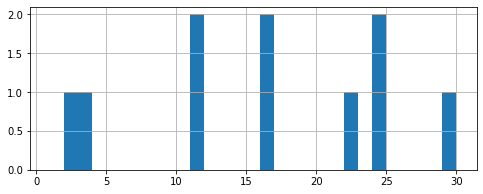

In [19]:
Results.loc[Results.PlayoffResult=='Champ'].TeamRank.hist(bins=range(1,31),xlabelsize=10,figsize=(8,3))

In [27]:
#Results.to_csv('MLB_Simulation_Results.csv')